In [33]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(10,6)})

model_name = 'final_model'

In [34]:
losses = torch.load(f'saved_model_params/refined_model/{model_name}_losses.pt')
print(losses)

[10.446015357971191, 5.922053337097168, 2.456547260284424, 3.2698862552642822, 1.066055417060852, 0.8493647575378418, 0.7058173418045044, 0.5981237292289734, 0.4770805835723877, 0.36006513237953186, 0.35343387722969055, 0.3983466625213623, 0.3355189859867096, 0.25092944502830505, 0.2283017933368683, 0.2283545732498169, 0.2179895043373108, 0.20917966961860657, 0.21060478687286377, 0.20325064659118652, 0.17622119188308716, 0.14969046413898468, 0.14312651753425598, 0.14968131482601166, 0.15375925600528717, 0.15266627073287964, 0.15157046914100647, 0.15093068778514862, 0.1463828682899475, 0.13877660036087036, 0.13442417979240417, 0.1351880580186844, 0.1368686556816101, 0.1368739753961563, 0.1368376910686493, 0.1372648924589157, 0.1356244683265686, 0.1314743459224701, 0.12802404165267944, 0.12712588906288147, 0.12724122405052185, 0.12706823647022247, 0.12724676728248596, 0.12791697680950165, 0.12778522074222565, 0.12647230923175812, 0.12522299587726593, 0.12454923987388611, 0.12375188618898

Text(0, 0.5, 'Loss')

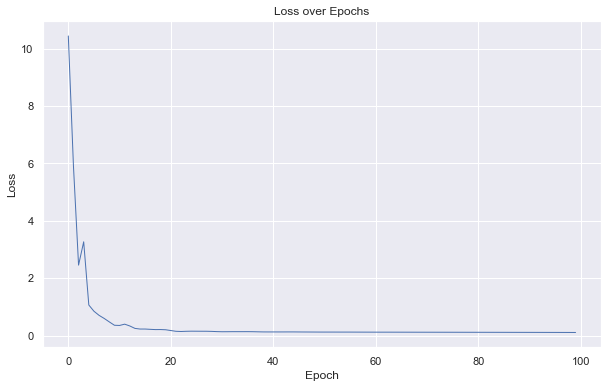

In [35]:
ax = sns.lineplot(losses, linewidth=1)
ax.set_title('Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


# Model Performance Visualizations

In [36]:
# Setup Model
from models.refined_model import GCN as GCN_Refined
from models.model import GCN

# model = GCN()
model = GCN_Refined(
    input_channels=2, output_channels=1, hidden_channels=8, num_hidden=4
)
model.load_state_dict(torch.load(f"saved_model_params/refined_model/{model_name}.pt"))
model = model.eval()
print(model)

GCN(
  (gconv_layers): ModuleList(
    (0): SAGEConv(2, 8, aggr=mean)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): SAGEConv(8, 8, aggr=mean)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SAGEConv(8, 8, aggr=mean)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SAGEConv(8, 8, aggr=mean)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): SAGEConv(8, 8, aggr=mean)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [37]:
data = torch.load("datasets/low_range/SG256_0_SM_5.pt")

y_truth = np.array([])
y_pred = np.array([])
dm_mass = np.array([])
redshift = np.array([])
for graph in data:
    graph.x = torch.tensor([[data[0], data[1]] for data in graph.x])

    # Logspace calcs
    graph.y = torch.log10(graph.y)
    graph.x[:, 0] = torch.log10(graph.x[:, 0])

    for item in graph.y:
        y_truth = np.append(y_truth, item)

    for item in graph.x:
        dm_mass = np.append(dm_mass, item[0])
        redshift = np.append(redshift, item[1])

    out = model(graph)
    for item in out.tolist():
        y_pred = np.append(y_pred, item[0])

# unlogspace
# y_truth = 10 ** y_truth
# y_pred = 10 ** y_pred

print(len(y_pred), "total halo snapshots")
print(len(data), "graphs")

16913 total halo snapshots
58 graphs


In [38]:
import scipy.stats
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import r2_score


def create_hexplot(
    x_bins: int,
    y_bins: int,
    x: any,
    y: any,
    x_label: str,
    y_label: str,
    title: str,
    display_stats: bool,
    display_yeqx: bool,
    median_std_overlay: bool = True,
    reverse_x: bool = False,
):
    # Create hexbin plot with custom color palette
    g = sns.color_palette(["lightgray", "darkgray", "black"])
    cmap_g = LinearSegmentedColormap.from_list("custom_gray_to_black", g)
    plt.hexbin(x, y, gridsize=(x_bins, y_bins), cmap=cmap_g, mincnt=1)

    # Create mean/std overlay
    if median_std_overlay:
        # Calculate median and standard deviation of Y values for each X bin
        x_bins_edges = np.linspace(min(x), max(x), x_bins + 1)
        y_median = [
            np.median(y[(x >= x_bins_edges[i]) & (x < x_bins_edges[i + 1])])
            for i in range(x_bins)
        ]
        y_std = [
            np.std(y[(x >= x_bins_edges[i]) & (x < x_bins_edges[i + 1])])
            for i in range(x_bins)
        ]
        x_bins_centers = 0.5 * (x_bins_edges[:-1] + x_bins_edges[1:])

        # Plot median and standard deviation as continuous functions
        plt.plot(x_bins_centers, y_median, color="turquoise", label="Median of Y")
        plt.fill_between(
            x_bins_centers,
            np.array(y_median) - np.array(y_std),
            np.array(y_median) + np.array(y_std),
            color="turquoise",
            alpha=0.3,
            label="Std Dev of Y",
        )
        if not display_yeqx:
            plt.legend(
                [f"Median of {y_label}"],
                loc="upper right",
                fontsize=14,
            )

    # Title
    plt.title(title, fontsize=22)

    # Create colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of Halo Snapshots", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Label axes
    plt.xlabel(x_label, fontsize=18, labelpad=15)
    if reverse_x:
        plt.gca().invert_xaxis()
    plt.ylabel(y_label, fontsize=18, labelpad=15)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Plot perfect predictions line y=x
    if display_yeqx:
        plt.plot([2, 5], [2, 5], ls="--", c="0")
        plt.legend(["Perfect Predictions"], loc="lower right", fontsize=14)
        if median_std_overlay:
            plt.legend(
                [f"Median of {y_label}", "Perfect Predictions"],
                loc="upper right",
                fontsize=14,
            )
        else:
            plt.legend(["Perfect Predictions"], loc="upper right", fontsize=14)

    plt.tight_layout()
    # plt.savefig("./images/figure1.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

    if display_stats:
        residuals = x - y
        print(f"Pearson correlation: {scipy.stats.pearsonr(x, y)}")
        print(f"MSE:  {np.mean(residuals**2)}")
        print(f"Mean absolute error: {np.mean(np.abs(residuals))} dex")
        print(f"Scatter: {scipy.stats.tstd(residuals)} dex")
        print(f"Bias: {np.mean(residuals)} dex")
        print(f"R^2: {r2_score(y_true=x, y_pred=y)}")

c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

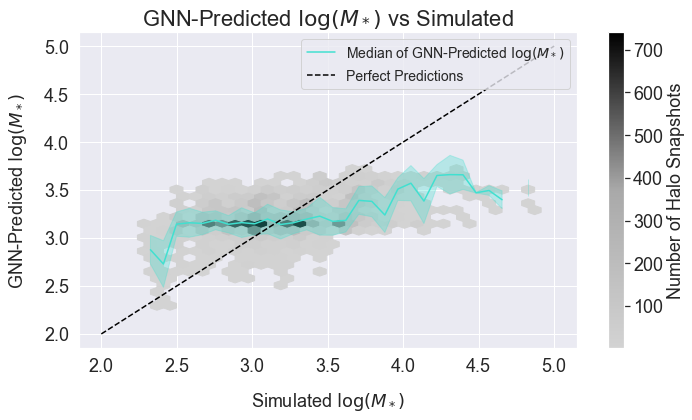

Pearson correlation: (0.41885819323438933, 0.0)
MSE:  0.11736050171974477
Mean absolute error: 0.28049134778178564 dex
Scatter: 0.3396800597514873 dex
Bias: -0.044550879324574306 dex
R^2: 0.16125743874616383


In [39]:
create_hexplot(30, 10, y_truth, y_pred, "Simulated $\log(M_*)$", "GNN-Predicted $\log(M_*)$", "GNN-Predicted $\log(M_*)$ vs Simulated", True, True)

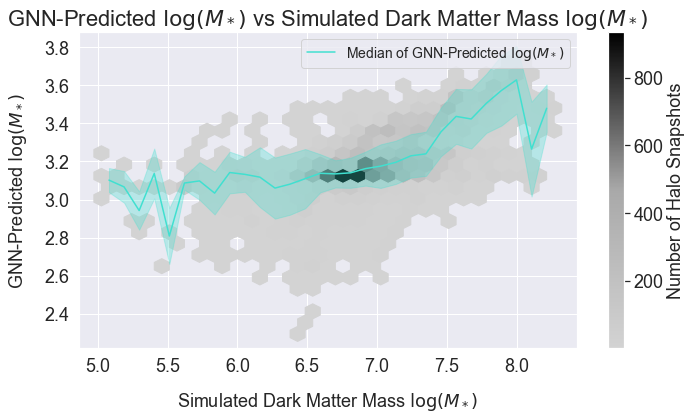

In [40]:
create_hexplot(30, 12, dm_mass, y_pred, "Simulated Dark Matter Mass $\log(M_*)$", "GNN-Predicted $\log(M_*)$", "GNN-Predicted $\log(M_*)$ vs Simulated Dark Matter Mass $\log(M_*)$", False, False)

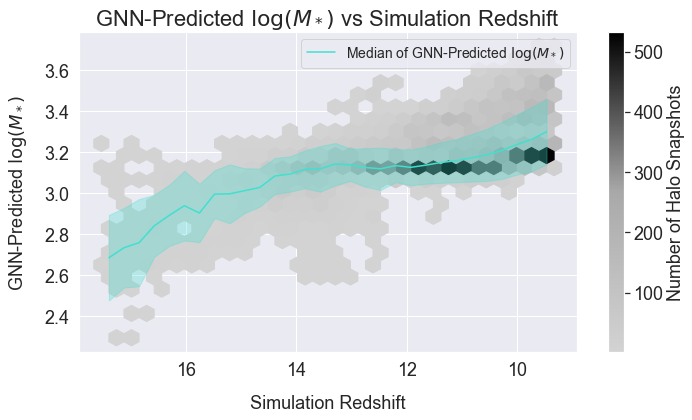

In [41]:
create_hexplot(30, 12, redshift, y_pred, "Simulation Redshift", "GNN-Predicted $\log(M_*)$", "GNN-Predicted $\log(M_*)$ vs Simulation Redshift", False, False, True, True)

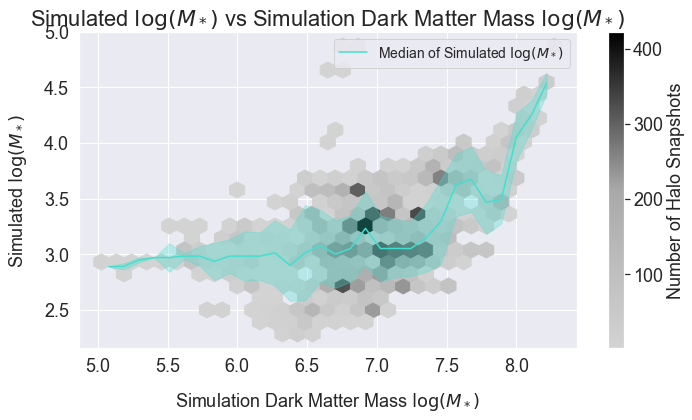

In [42]:
create_hexplot(30, 12, dm_mass, y_truth, "Simulation Dark Matter Mass $\log(M_*)$", "Simulated $\log(M_*)$", "Simulated $\log(M_*)$ vs Simulation Dark Matter Mass $\log(M_*)$", False, False)

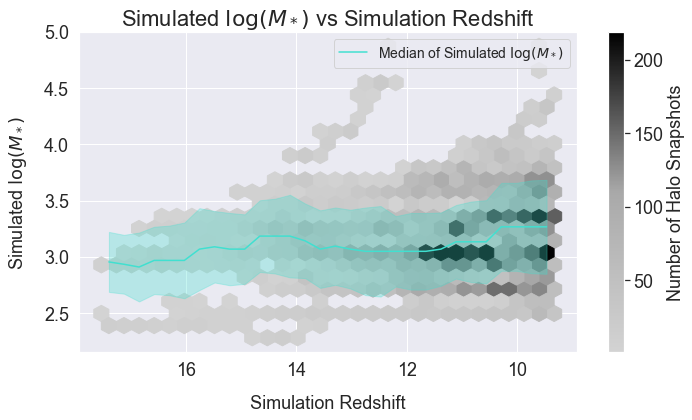

In [43]:
create_hexplot(30, 12, redshift, y_truth, "Simulation Redshift", "Simulated $\log(M_*)$", "Simulated $\log(M_*)$ vs Simulation Redshift", False, False, True, True)